# Clean & Visualize Taiwan Weather Data over Time

## 1. Append 1961-2018

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

path = r'C:\Users\jing007\Documents\temporal\data raw'

# List all files in the directory
files_in_directory = os.listdir(path)
csv_files = [file for file in files_in_directory if file.endswith('.csv')]

def read_csv_file(file_path):
    """Read a CSV file and return a DataFrame."""
    df = pd.read_csv(file_path, index_col=0)
    return df

# Define the directory path
path = r'C:\Users\jing007\Documents\temporal\data raw'

# List CSV files in the directory
csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

# Create a ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Future to dataframe mapping
    future_to_df = {executor.submit(read_csv_file, os.path.join(path, csv_file)): csv_file for csv_file in csv_files}
    
    # Initialize an empty list to collect DataFrames
    dataframes = []
    
    # Process as each future completes
    for future in as_completed(future_to_df):
        try:
            dataframes.append(future.result())
        except Exception as e:
            csv_file = future_to_df[future]
            print(f"Exception reading file {csv_file}: {e}")

# Append all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.sort_values(by=['stno', 'yyyymmddhh'], inplace=True)

# Replace -9999 with NaN
combined_df = combined_df.replace(-9999, pd.NA)



C:\Users\jing007\AppData\Local\Temp\ipykernel_4652\2359403577.py:7: DtypeWarning: Columns (28,29,30,38,39,40,42,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, index_col=0)


In [5]:
combined_df.to_csv(r'C:\Users\jing007\Documents\temporal\data clean\cwb1961-2018.csv', index=False)

In [6]:
combined_df.tail()

,stno,yyyymmddhh,PS01,PS02,TX01,TX04,TX05,RH01,RH02,WD01,...,ST04,ST05,ST06,ST07,ST08,ST09,ST10,ST11,ST12,SN
130315,467990,2018063020,995.6,1006.1,26.9,<NA>,25.2,90,32.1,1.7,...,<NA>,<NA>,<NA>,<NA>,<NA>,9,<NA>,<NA>,<NA>,NaN
130316,467990,2018063021,995.6,1006.1,26.8,<NA>,25.2,91,32.1,1.1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
130317,467990,2018063022,995.6,1006.1,26.7,<NA>,25.1,91,31.9,1.2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
130318,467990,2018063023,995.3,1005.8,26.8,<NA>,25.4,92,32.4,0.7,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
130319,467990,2018063024,995.6,1006.1,26.7,<NA>,25.2,92,32.1,0.5,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


## 2. Identify time gap (missing data across time)

In [18]:
import pandas as pd

combined_df = pd.read_csv(r'C:\Users\jing007\Documents\temporal\data clean\cwb1961-2018.csv')

C:\Users\jing007\AppData\Local\Temp\ipykernel_4652\2751403504.py:3: DtypeWarning: Columns (26,27,28,36,37,38,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(r'C:\Users\jing007\Documents\temporal\data clean\cwb1961-2018.csv')


In [20]:
# keep only 2 decades of data - example for plotting & gap identifying
df2 = combined_df[combined_df['yyyymmddhh'] < 1980123100]

In [21]:
# Find rows where TX01 is missing
missing_tx01 = df2[df2['TX01'].isna()]

# Extract the station numbers and dates for the missing TX01 values
missing_tx01_stations_dates = missing_tx01[['stno', 'yyyymmddhh']]

# Print or output the station numbers and dates with missing TX01 values
print(missing_tx01_stations_dates)

            stno  yyyymmddhh
144600    466900  1961010101
144601    466900  1961010102
144603    466900  1961010104
144604    466900  1961010105
144606    466900  1961010107
...          ...         ...
12532351  467770  1980123016
12532353  467770  1980123018
12532354  467770  1980123019
12532357  467770  1980123022
12532359  467770  1980123024

[1826341 rows x 2 columns]


In [31]:
df2_reset = df2.reset_index()
# Convert 'yyyymmddhh' to a datetime object
df2_reset['yyyymmddhh'] = pd.to_datetime(df2_reset['yyyymmddhh'], format='%Y%m%d%H', errors='coerce')

Example stno: 466900	
Use it to visualize temperature data, then interpolate

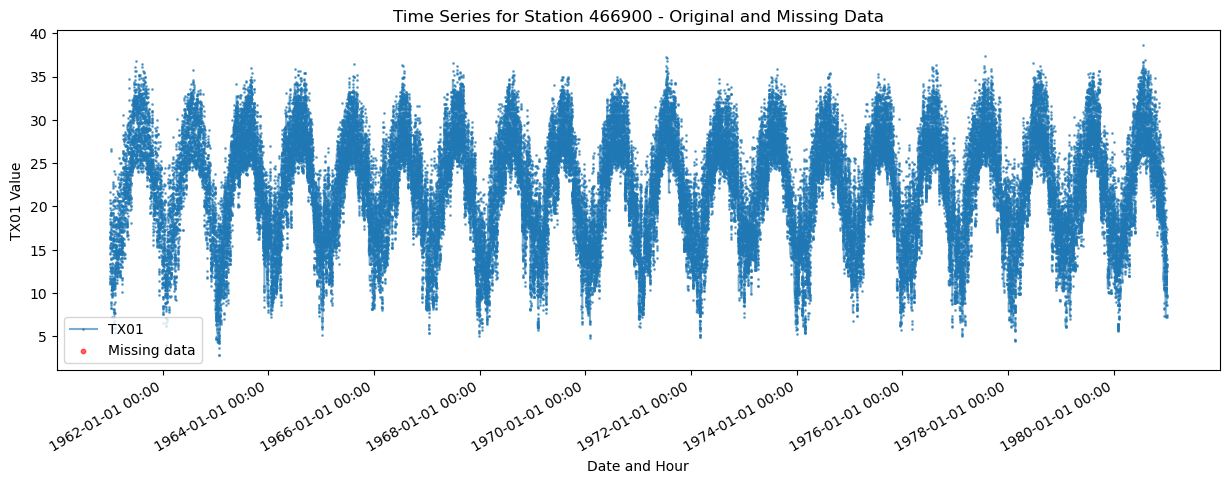

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

station_number = 466900
df_subset = df2_reset[df2_reset['stno'] == station_number]
df_subset = df_subset[df_subset.index.notna()]

# Define buffer for x-axis whitespace (e.g., 5% of your date range)
buffer_percent = 0.05
date_range = (df_subset.index.max() - df_subset.index.min()).days
date_buffer = pd.Timedelta(days=date_range * buffer_percent)

# Set the plot figure
plt.figure(figsize=(15, 5))

# Plot original TX01 values
plt.plot(df_subset.index, df_subset['TX01'], marker='o', linestyle='-', label='TX01', markersize=1, alpha=0.6)

# Highlight missing data in red
missing_data = df_subset['TX01'].isna()
plt.scatter(df_subset.index[missing_data], df_subset['TX01'][missing_data], color='red', label='Missing data', s=10, alpha=0.6)

# Set the x-axis limits with buffer
plt.xlim([df_subset.index.min() - date_buffer, df_subset.index.max() + date_buffer])

# Improve the date formatting on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15))
plt.gcf().autofmt_xdate()  # Auto-format the dates to prevent overlap

plt.xlabel('Date and Hour')
plt.ylabel('TX01 Value')
plt.title(f'Time Series for Station {station_number} - Original and Missing Data')
plt.legend()
plt.show()

Check missing data in which hours

In [91]:
# Set the 'yyyymmddhh' column as the index if it isn't already
df_subset = df_subset.set_index('yyyymmddhh', drop=True)

# Extract the hour since the index is a DateTimeIndex
df_subset['hour'] = df_subset.index.hour

# Filter to get only the rows where TX01 is missing
missing_tx01 = df_subset[df_subset['TX01'].isna()]

# Count the number of missing data points for each hour
missing_data_by_hour = missing_tx01.groupby('hour').size()

# Output the count of missing data by hour
print(missing_data_by_hour)

hour
1.0     7304
2.0      730
3.0     6574
4.0     7304
5.0      729
6.0     6574
7.0     7304
8.0      731
10.0    7304
11.0     730
12.0    6574
13.0    7304
15.0    7304
16.0    7304
17.0     730
18.0    6573
19.0    7304
20.0     730
22.0    7304
23.0     730
dtype: int64


Missing air temperature is not uniformly distributed across hours.Roughtly measured every 3 hours. So interpolate or not is insignificant

Interpolate TX01 (air temperature) for this station in this 2-decade subset

In [93]:
# Interpolate directly in the original scale
df_subset2 = df_subset
df_subset2 = df_subset2[df_subset2.index.notna()]
df_subset2 = df_subset2.reset_index()

# Convert the 'yyyymmddhh' column back to a DateTimeIndex
df_subset2['yyyymmddhh'] = pd.to_datetime(df_subset2['yyyymmddhh'])
df_subset2 = df_subset2.set_index('yyyymmddhh')


In [94]:
df_subset2['TX01'].interpolate(method = 'spline',order=3, inplace = True)

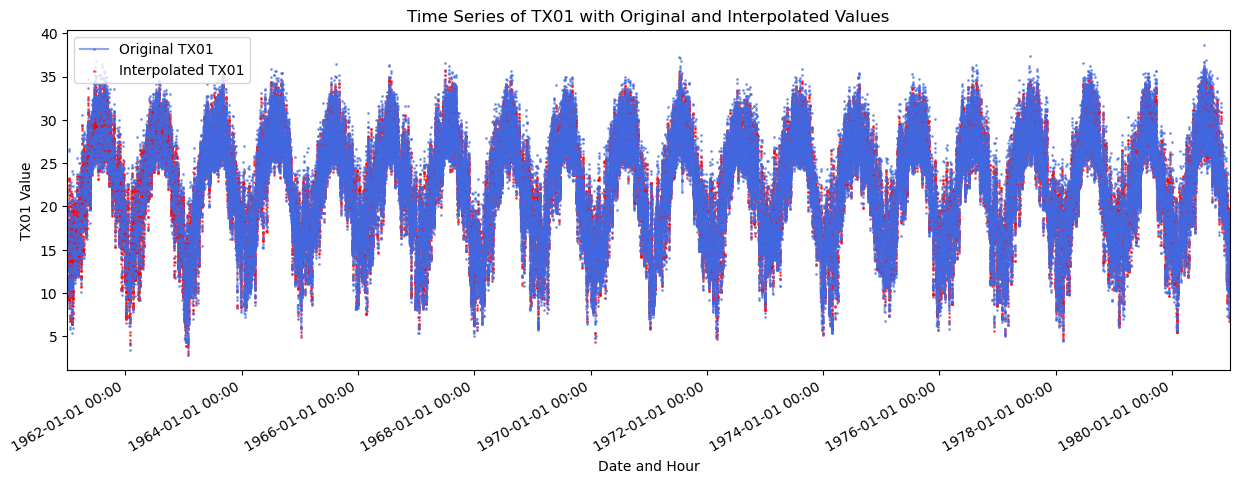

In [129]:
# Backfilling missing values
df_subset2['TX01'].fillna(method='bfill', inplace=True)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a boolean mask where the data in df_subset2 is different from df_subset
# We need to reindex df_subset2 to df_subset for direct comparison
interpolated_mask = df_subset2.reindex(df_subset.index)['TX01'] != df_subset['TX01']

# Start plotting
plt.figure(figsize=(15, 5))

# Plot all original values in blue
plt.plot(df_subset.index, df_subset['TX01'], marker='o', linestyle='-', label='Original TX01', color='royalblue', markersize=1, alpha=0.6)

# Overlay the interpolated values in red
plt.scatter(df_subset2.index[interpolated_mask], df_subset2['TX01'][interpolated_mask], color='red', label='Interpolated TX01', s=1, alpha=0.6)

# Improve the date formatting on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Auto-format the dates to prevent overlap

# Set the x-axis limits to include the full range of dates
plt.xlim(df_subset.index.min(), df_subset.index.max())

# Labeling
plt.xlabel('Date and Hour')
plt.ylabel('TX01 Value')
plt.title('Time Series of TX01 with Original and Interpolated Values')
plt.legend()

# Show the plot
plt.show()



In [132]:
# For the original dataset without interpolation
# Ensure that the DataFrame has a datetime index and filter the required years
df_subset = df_subset[(df_subset.index.year >= 1961) & (df_subset.index.year <= 1980)]

# Create 'yearmonth' column
df_subset['yearmonth'] = df_subset.index.to_period('M')

# Group by 'yearmonth' and calculate mean
monthly_means_original = df_subset.groupby('yearmonth')['TX01'].mean()

# Convert the Series to a DataFrame
monthly_means_original_df = monthly_means_original.to_frame(name='Tave')

# For the interpolated dataset
# Ensure that the DataFrame has a datetime index and filter the required years
df_subset2 = df_subset2[(df_subset2.index.year >= 1961) & (df_subset2.index.year <= 1980)]

# Create 'yearmonth' column
df_subset2['yearmonth'] = df_subset2.index.to_period('M')

# Group by 'yearmonth' and calculate mean
monthly_means_interpolated = df_subset2.groupby('yearmonth')['TX01'].mean()

# Convert the Series to a DataFrame
monthly_means_interpolated_df = monthly_means_interpolated.to_frame(name='Tave')


In [133]:
df_subset.head()

,stno,PS01,PS02,TX01,TX04,TX05,RH01,RH02,WD01,WD02,...,Tave04,Tave05,Tave06,Tave07,Tave08,Tave09,Tave10,Tave11,Tave12,yearmonth
yyyymmddhh,,,,,,,,,,,,,,,,,,,,,
1961-01-01 01:00:00,466900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.466529,24.693415,26.854021,28.931909,28.636365,27.042027,23.685185,20.41201,16.961626,1961-01
1961-01-01 02:00:00,466900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.466529,24.693415,26.854021,28.931909,28.636365,27.042027,23.685185,20.41201,16.961626,1961-01
1961-01-01 03:00:00,466900,1023.8,NaN,11.7,NaN,5.3,65.0,8.9,1.3,67.5,...,21.466529,24.693415,26.854021,28.931909,28.636365,27.042027,23.685185,20.41201,16.961626,1961-01
1961-01-01 04:00:00,466900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.466529,24.693415,26.854021,28.931909,28.636365,27.042027,23.685185,20.41201,16.961626,1961-01
1961-01-01 05:00:00,466900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.466529,24.693415,26.854021,28.931909,28.636365,27.042027,23.685185,20.41201,16.961626,1961-01


In [134]:
df_subset2.head()

,stno,PS01,PS02,TX01,TX04,TX05,RH01,RH02,WD01,WD02,...,Tave04,Tave05,Tave06,Tave07,Tave08,Tave09,Tave10,Tave11,Tave12,yearmonth
yyyymmddhh,,,,,,,,,,,,,,,,,,,,,
1961-01-01 01:00:00,466900,NaN,NaN,11.700000,NaN,NaN,NaN,NaN,NaN,NaN,...,21.503899,24.749308,26.943864,29.004855,28.715057,27.121246,23.738647,20.468213,17.014138,1961-01
1961-01-01 02:00:00,466900,NaN,NaN,11.700000,NaN,NaN,NaN,NaN,NaN,NaN,...,21.503899,24.749308,26.943864,29.004855,28.715057,27.121246,23.738647,20.468213,17.014138,1961-01
1961-01-01 03:00:00,466900,1023.8,NaN,11.700000,NaN,5.3,65.0,8.9,1.3,67.5,...,21.503899,24.749308,26.943864,29.004855,28.715057,27.121246,23.738647,20.468213,17.014138,1961-01
1961-01-01 04:00:00,466900,NaN,NaN,11.962878,NaN,NaN,NaN,NaN,NaN,NaN,...,21.503899,24.749308,26.943864,29.004855,28.715057,27.121246,23.738647,20.468213,17.014138,1961-01
1961-01-01 05:00:00,466900,NaN,NaN,12.621594,NaN,NaN,NaN,NaN,NaN,NaN,...,21.503899,24.749308,26.943864,29.004855,28.715057,27.121246,23.738647,20.468213,17.014138,1961-01


the monthly temperature, after inpolation, increased by about 0.1 C.

In [135]:
df_subset2.to_csv(r'C:\Users\jing007\Documents\temporal\data clean\interpolated cwb 1 station 1961-1980.csv', index=False)
df_subset.to_csv(r'C:\Users\jing007\Documents\temporal\data clean\no interpolation cwv 1 station 1961-1990.csv', index=False)